In [8]:
# Purpose of this to carry out the following:
    # explore features we already have and create new ones
    # once that is done, carry out an appropriate train/test/validate split - taking temporal validation into account
    # pre processing (impute missingness separately for train/test/validate, normalize, etc)

# The datasets used are the datasets created by build_dataset - they're
# too big for github, so they have been uploaded to google drive. They should
# be downloaded into your local data folder to be imported in this notebook

# The end goal of this notebook is to have our final datasets ready for analysis
# this code should then be moved into our .py files so the notebook can eventually be deleted

In [1]:
import sqlite3
from sqlite3 import Error
import pandas as pd
import config
import os.path
from os import path

#from create_db import create_connection, create_table, clean_column_names
#from populate_db import extract_data, insert_records
#import query_db as qd

import importlib

import datetime
import re
import numpy as np

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [93]:
# Import datasets created in build_dataset

dataset_main = pd.read_csv('../data/dataset_main.csv')
dataset_active_sentences = pd.read_csv('../data/active_sentences.csv')

In [4]:
dataset_main.head()

,ID,COMMITMENT_PREFIX,EARLIEST_SENTENCE_EFFECTIVE_DT,MOST_SERIOUS_OFFENSE_CODE,INMATE_COMPUTATION_STATUS_FLAG,END_DATE,PROJ_END_DATE,INMATE_RECORD_STATUS_CODE,INMATE_ADMIN_STATUS_CODE,DATE_OF_LAST_INMATE_MOVEMENT,TYPE_OF_LAST_INMATE_MOVEMENT,CURRENT_COMMITMENT_PREFIX,CONTROL_STATUS,GENDER,RACE,BIRTH_DATE,STATE_BORN,ETHNICITY,CITIZENSHIP,DISCIPLINARY_INFRACTION_COUNT,NextPrefix,NextStart,NextOffense,new_col,Time_Diff,Recidivate,Primary offense code,Description (if needed),Decided Category,Needed a check?,More lenient,More harsh
0,4,AA,1983-07-12,NaN,EXPIRED,1984-07-11,1984-07-11,INACTIVE,INACTIVE,1984-07-11,TERMINATED PAROLE,NaN,REGULAR POPULATION RPOP,MALE,WHITE,1961-10-15,ALASKA,UNKNOWN,BORN IN U.S.,NaN,0,NaN,0,0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0
1,6,AA,1973-01-30,NaN,EXPIRED,1973-03-28,0001-01-01,INACTIVE,INACTIVE,1975-08-18,TERMINATED PAROLE,NaN,REGULAR POPULATION RPOP,MALE,WHITE,1951-07-17,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,NaN,AB,1973-04-11,NaN,1973,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,6,AB,1973-04-11,NaN,EXPIRED,1975-08-18,1974-08-10,INACTIVE,INACTIVE,1975-08-18,TERMINATED PAROLE,NaN,REGULAR POPULATION RPOP,MALE,WHITE,1951-07-17,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,NaN,0,NaN,0,0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0
3,8,AA,1990-04-09,NaN,EXPIRED,1990-05-17,1990-10-09,INACTIVE,INACTIVE,1995-09-14,TERMINATED PAROLE,NaN,REGULAR POPULATION RPOP,MALE,WHITE,1963-12-29,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,NaN,AB,1993-08-30,NaN,1993,3.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0
4,8,AB,1993-08-30,NaN,EXPIRED,1994-01-26,1994-02-18,INACTIVE,INACTIVE,1995-09-14,TERMINATED PAROLE,NaN,REGULAR POPULATION RPOP,MALE,WHITE,1963-12-29,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,NaN,BA,1995-01-02,NaN,1995,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
dataset_main.isnull().sum()

ID                                     0
COMMITMENT_PREFIX                      0
EARLIEST_SENTENCE_EFFECTIVE_DT         0
MOST_SERIOUS_OFFENSE_CODE         308659
INMATE_COMPUTATION_STATUS_FLAG         0
END_DATE                               0
PROJ_END_DATE                          0
INMATE_RECORD_STATUS_CODE           6216
INMATE_ADMIN_STATUS_CODE            6216
DATE_OF_LAST_INMATE_MOVEMENT        6216
TYPE_OF_LAST_INMATE_MOVEMENT       15212
CURRENT_COMMITMENT_PREFIX         202165
CONTROL_STATUS                      6216
GENDER                                 0
RACE                                   2
BIRTH_DATE                             0
STATE_BORN                         29626
ETHNICITY                            692
CITIZENSHIP                          669
DISCIPLINARY_INFRACTION_COUNT     310201
NextPrefix                             0
NextStart                         430781
NextOffense                       111635
new_col                                0
Time_Diff       

In [7]:
# Decisions to be made:
    # Which variables to keep?
    # Which features need to be constructed from the available variables?
    # How do we want to deal with missings?
        # e.g. impute? choose majority? some notes here: https://towardsdatascience.com/working-with-missing-data-in-machine-learning-9c0a430df4ce
        
# A first pass, following this group: https://bucklerd.github.io/MUSA801_Recidivism_Markdown/#
    # Race - keep
    # Sex - keep
    # Age at each sentence - need to calculate using birth date and effective sentence begin date - more indifferent
    # Age category each sentence - keep, look at literature to decide how to categorize
    # Ethnicity - keep
    # Citizenship - keep, but just look at variation, don't include in model
    # Age at first incarceration? Could compute as age at first sentence - keep, similar information to age category
    # Most serious current offense (since there are so many categories, do we want to map on our coded 5 point scale
        # to this..?)
        # - different versions of this (most serious offense, and turn everything else to other), one-hot encoding
        # - with 5 point scale 
    # Current crime violent or not violent (not sure where they are gtting this from, or if its self constructed)
        # - our scale 4-5 to 1, our scale 1-3 is 0 (self-constructed)
        # - feel iffy about this, so also try leaving out
    # Total sentence count - can be computed - lots of bias baked in? - would be at the individual level?
        # - keep, and see how it affects the model (prior history context)
    # Juvenile Offense Flag - would need to construct using age at first incarceration - keep
    # total count of felony and misdemeanor charges - i think these can be calculated from sentence component
        # would be at the individual level not sentence level? 
        # - keep, for the sentence that got a recidivate flag, how many flags in either category
    # custody_class_code - i think this CONTROL_STATUS
        # individual level not sentence level - don't keep (probably adds more bias than value...)
    # special characteristics - i didn't really know how to make sense of this, so i didn't include it for now...
    # - - don't keep (probably adds more bias than value...)
    # total disciplinary infractions - would be at the individual level not the sentence level
        # although this comes from a file that has infraction by date so in theory
        #   we could calculate at the sentence level with some SQL maneouvering 
        # how many infractions between each start/end date of the sentence, but this would be a bit more complicated
    # Type of last inmate movement - we have this, but i'm not sure how much value it adds. also its at the
        # offender level, not sentence level - don't keep 
    

# Thoughts on missingness:
    # Race, Sex, Birth date - basically not missing, can drop or impute couple that are
    # Ethnicity and Citizenship - Majority impute?
    # Most serious current offense - already working on trying to make this less missing
    # Disciplinary infractions - the way this is constructed is by merging on from a file that contains
        # infractions. So i think it is safe to assume that if this variable is missing for an individual,
        # they did not commit any infractions. replace with 0?
    # 
        
    
    

### Decisions:

*First model is most parsimonious
* Bring in median household income and unemployment data so the predictor mechanism isn't just on individual (maybe NC, annual)

### Splitting the work:
* Damini: (pulling via SQL)
    - Disciplinary infractions
    - Most serious current offense
    - Current crime violent
    - Total count of felony and misdemeanor charges
    - Total sentence count
    
* Charmaine:
    - Median HH income
    - Unemployment
    - Age at each sentence - need to calculate using birth date and effective sentence begin date - more indifferent
    - Age category each sentence - keep, look at literature to decide how to categorize
    - Age at first incarceration? Could compute as age at first sentence - keep, similar information to age category
    - Juvenile Offense Flag

### Charmaine's WIP code:

In [94]:
# Check how many observations you have and make sure you don't drop any while creating new features
dataset_main.shape

(850970, 32)

In [95]:
# Create AGE_AT_SENTENCE
dataset_main['EARLIEST_SENTENCE_EFFECTIVE_DT'] = pd.to_datetime(dataset_main['EARLIEST_SENTENCE_EFFECTIVE_DT'], yearfirst=True)
dataset_main.loc[dataset_main['BIRTH_DATE'] == '0001-01-01', 'BIRTH_DATE'] = np.NaN
dataset_main['BIRTH_DATE'] = pd.to_datetime(dataset_main['BIRTH_DATE'], format='%Y/%m/%d')

dataset_main['age_at_sentence'] = (dataset_main['EARLIEST_SENTENCE_EFFECTIVE_DT'] - dataset_main['BIRTH_DATE']).astype('<m8[Y]')
dataset_main['age_at_sentence'].describe()


count    850757.000000
mean         30.663668
std          10.233581
min         -53.000000
25%          22.000000
50%          29.000000
75%          37.000000
max          90.000000
Name: age_at_sentence, dtype: float64

In [96]:
# Check number of misisng
dataset_main['age_at_sentence'].isnull().sum()

213

In [97]:
# Check observations where age is negative
dataset_main.loc[dataset_main['age_at_sentence'] < 0, ['EARLIEST_SENTENCE_EFFECTIVE_DT', 'BIRTH_DATE']]

# Convert to NaN?
dataset_main.loc[dataset_main['age_at_sentence'] < 0, ['age_at_sentence']] = np.NaN

# Check number of missing
dataset_main['age_at_sentence'].isnull().sum()

239

In [98]:
# Create age categories
# Resources: https://www.ussc.gov/research/research-reports/effects-aging-recidivism-among-federal-offenders
dataset_main['age_cat'] = pd.cut(dataset_main['age_at_sentence'],
                                 bins=[0,17,21,24,29,34,39,44,49,54,59,64,90],
                                 labels=['Under 18', '18-21','22-24','25-29','30-34','35-39','40-44','45-49',
                                        '50-54','55-59','60-64','65 and older',])

In [99]:
dataset_main.groupby(['age_cat']).size()

age_cat
Under 18         33802
18-21           143052
22-24           110353
25-29           163265
30-34           131594
35-39           101834
40-44            72703
45-49            47397
50-54            26346
55-59            12483
60-64             5206
65 and older      2694
dtype: int64

In [100]:
# Compute age at first incarceration
first_incarceration = pd.DataFrame(dataset_main.groupby(['ID'])['EARLIEST_SENTENCE_EFFECTIVE_DT'].min().reset_index(name='first_incarceration_date'))
dataset_main = dataset_main.merge(first_incarceration, on='ID')

In [101]:
dataset_main[['ID','COMMITMENT_PREFIX','EARLIEST_SENTENCE_EFFECTIVE_DT','first_incarceration_date']].head()

,ID,COMMITMENT_PREFIX,EARLIEST_SENTENCE_EFFECTIVE_DT,first_incarceration_date
0,4,AA,1983-07-12,1983-07-12
1,6,AA,1973-01-30,1973-01-30
2,6,AB,1973-04-11,1973-01-30
3,8,AA,1990-04-09,1990-04-09
4,8,AB,1993-08-30,1990-04-09


In [102]:
# Flag for juvenile offense
dataset_main['age_first_offense'] = (dataset_main['first_incarceration_date'] - dataset_main['BIRTH_DATE']).astype('<m8[Y]')
dataset_main['age_first_offense'].describe()

count    850757.000000
mean         26.353506
std           9.212223
min         -53.000000
25%          19.000000
50%          24.000000
75%          31.000000
max          90.000000
Name: age_first_offense, dtype: float64

In [103]:
# Check observations where age is negative
dataset_main.loc[dataset_main['age_first_offense'] < 0, ['EARLIEST_SENTENCE_EFFECTIVE_DT', 'BIRTH_DATE']]

,EARLIEST_SENTENCE_EFFECTIVE_DT,BIRTH_DATE
24763,1977-07-07,1992-07-18
39794,1962-05-17,1999-10-29
40918,1976-09-23,1997-09-18
60491,1973-05-21,1999-09-28
66448,1954-11-13,1996-10-08
74139,1973-05-02,1996-10-14
74140,1973-06-29,1996-10-14
105478,1973-05-09,1985-09-20
114817,1946-03-10,1998-09-15
156529,1986-11-19,1986-12-24


In [120]:
#dataset_main[dataset_main['age_first_offense'] < 10].count()

ID                                44
COMMITMENT_PREFIX                 44
EARLIEST_SENTENCE_EFFECTIVE_DT    44
MOST_SERIOUS_OFFENSE_CODE         24
INMATE_COMPUTATION_STATUS_FLAG    44
END_DATE                          44
PROJ_END_DATE                     44
INMATE_RECORD_STATUS_CODE         44
INMATE_ADMIN_STATUS_CODE          44
DATE_OF_LAST_INMATE_MOVEMENT      44
TYPE_OF_LAST_INMATE_MOVEMENT      44
CURRENT_COMMITMENT_PREFIX         35
CONTROL_STATUS                    44
GENDER                            44
RACE                              44
BIRTH_DATE                        44
STATE_BORN                        44
ETHNICITY                         44
CITIZENSHIP                       44
DISCIPLINARY_INFRACTION_COUNT     24
NextPrefix                        44
NextStart                         29
NextOffense                       38
new_col                           44
Time_Diff                         29
Recidivate                        44
Primary offense code              23
D

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12e5d2d30>]],
      dtype=object)

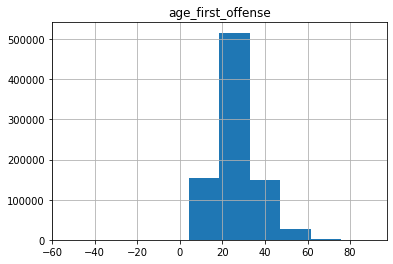

In [104]:
import matplotlib.pyplot

dataset_main.hist(column=['age_first_offense'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14e426f60>]],
      dtype=object)

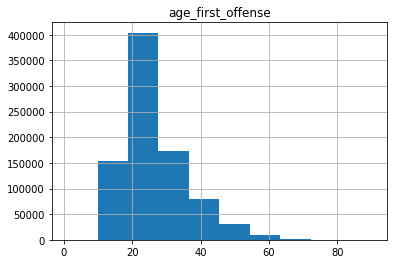

In [105]:
dataset_main[dataset_main['age_first_offense'] > 0].hist(column=['age_first_offense'])

In [106]:
# Convert to NaN?
dataset_main.loc[dataset_main['age_first_offense'] < 0, ['age_first_offense']] = np.NaN

# Check number of misisng
dataset_main['age_first_offense'].isnull().sum()

239

In [107]:
dataset_main['juv_first_offense'] = (dataset_main['age_first_offense'] < 18)
dataset_main.sort_values('age_first_offense')[['BIRTH_DATE','first_incarceration_date','age_first_offense', 'juv_first_offense']].head(10)

,BIRTH_DATE,first_incarceration_date,age_first_offense,juv_first_offense
362030,1974-01-18,1974-12-18,0.0,True
132060,1978-03-09,1978-05-09,0.0,True
285722,1990-05-24,1992-05-14,1.0,True
478839,1991-08-21,1993-09-07,2.0,True
156078,1974-12-21,1977-11-03,2.0,True
253179,1967-01-27,1970-08-11,3.0,True
253178,1967-01-27,1970-08-11,3.0,True
251178,1989-04-28,1993-09-29,4.0,True
251179,1989-04-28,1993-09-29,4.0,True
419562,1984-05-10,1990-03-19,5.0,True


### TO DISCUSS
A lot of these dates don't make sense. How can a toddler be sentenced?

* Replace with NaN if below 10 (talked with Damini about this)
* Maybe impute to mean/median eventually.
* We could trim the data to start at 1976

In [108]:
dataset_main.sort_values('age_first_offense')[['BIRTH_DATE','first_incarceration_date','age_first_offense', 'juv_first_offense']].sample(10)

,BIRTH_DATE,first_incarceration_date,age_first_offense,juv_first_offense
319202,1968-01-17,1986-09-04,18.0,False
86938,1950-12-29,1990-10-16,39.0,False
803470,1991-12-21,2011-01-15,19.0,False
655654,1951-07-17,2001-06-14,49.0,False
236722,1952-09-22,2003-05-07,50.0,False
836216,1983-11-06,2014-11-05,30.0,False
677495,1985-03-26,2003-04-22,18.0,False
812912,1978-12-28,2013-03-07,34.0,False
716339,1985-12-18,2009-09-23,23.0,False
763406,1966-09-08,2013-12-09,47.0,False


### Pull in unemployment data
* Source: BLS LAUS
* Link: https://beta.bls.gov/dataViewer/view/timeseries/LASST370000000000003

In [109]:
dataset_main['EARLIEST_SENTENCE_EFFECTIVE_DT'].describe()

count                  850970
unique                  16448
top       2009-01-12 00:00:00
freq                      217
first     1921-09-30 00:00:00
last      2020-04-20 00:00:00
Name: EARLIEST_SENTENCE_EFFECTIVE_DT, dtype: object

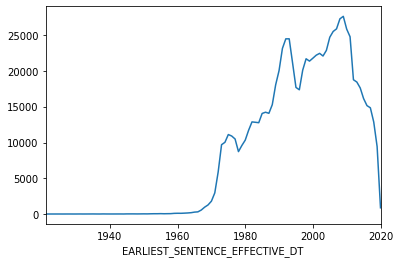

In [110]:
dataset_main.groupby([dataset_main['EARLIEST_SENTENCE_EFFECTIVE_DT'].dt.year]).size().plot(kind="line")

The earliest data BLS has only goes to 1976...
### TO DISCUSS
Should we restrict our data to 1976? We would end up dropping 5% of our data. 

Or 1984? (see median HH income data limitations below...)

In [111]:
# Import downloaded CSV
unemployment = pd.read_csv('../data/unemployment_nc.csv')

In [112]:
unemployment.head()

,Series ID,Year,Period,Label,Value
0,LASST370000000000003,1976,M01,1976 Jan,6.5
1,LASST370000000000003,1976,M02,1976 Feb,6.5
2,LASST370000000000003,1976,M03,1976 Mar,6.4
3,LASST370000000000003,1976,M04,1976 Apr,6.3
4,LASST370000000000003,1976,M05,1976 May,6.1


In [113]:
unemployment['month'] = unemployment['Period'].str[1:]
unemployment['Year'] = unemployment['Year'].astype(str)
unemployment['date_to_merge'] = unemployment['Year'].str.cat(unemployment['month'], sep ="-")
unemployment['date_to_merge'].head()

0    1976-01
1    1976-02
2    1976-03
3    1976-04
4    1976-05
Name: date_to_merge, dtype: object

In [114]:
# Create a str column to merge on
dataset_main['date_to_merge'] = dataset_main['EARLIEST_SENTENCE_EFFECTIVE_DT'].dt.strftime('%Y-%m')

# Rename variables 
unemployment = unemployment.rename(columns={"Value": "unemp_rate"})
unemployment_limited = unemployment[['date_to_merge','unemp_rate']]

# Merge with unemployment data
dataset_main = dataset_main.merge(unemployment_limited, on='date_to_merge', how='left')
check_cols = ['EARLIEST_SENTENCE_EFFECTIVE_DT','date_to_merge','unemp_rate']
dataset_main[check_cols].sample(10)

,EARLIEST_SENTENCE_EFFECTIVE_DT,date_to_merge,unemp_rate
333657,1983-04-18,1983-04,9.7
269053,1974-10-14,1974-10,NaN
293941,1994-09-06,1994-09,4.4
149234,2000-01-05,2000-01,3.3
807184,2013-11-12,2013-11,7.1
268683,1996-01-22,1996-01,4.6
9882,2007-01-30,2007-01,4.7
664796,2006-11-13,2006-11,4.8
53035,1985-12-31,1985-12,4.9
626186,2017-10-04,2017-10,4.3


In [116]:
# Check how many are missing
dataset_main['unemp_rate'].isnull().sum() / dataset_main.shape[0]

0.05415702081154447

### Pull in median household income
* Source: Table H-8
* Links: 
  * https://www.census.gov/data/tables/time-series/demo/income-poverty/historical-income-households.html
  * https://fred.stlouisfed.org/series/MEHOINUSA672N
* Note: Only has 1984-2018?

In [118]:
hh_inc = pd.read_excel('../data/h08.xls', sheet_name='edited', usecols=['Year','Median HH Income'], nrows=38)

In [121]:
hh_inc

,Year,Median HH Income
0,2018,53369
1,2017,49547
2,2017 (40),50343
3,2016,53764
4,2015,50797
5,2014,46784
6,2013 (39),46337
7,2013 (38),41208
8,2012,41553
9,2011,45206


#### Source: https://www.census.gov/topics/income-poverty/income/guidance/cps-historic-footnotes.html

36.	Beginning with 2009 income data, the Census Bureau expanded the upper income interval used to calculate medians and Gini indexes to \\$250,000 or more. Medians falling in the upper open-ended interval are plugged with "\\$250,000." Before 2009, the upper open-ended interval was \\$100,000 and a plug of "\\$100,000" was used.

37.	Implementation of Census 2010-based population controls.

38.	The 2014 CPS ASEC included redesigned questions for income and health insurance coverage. All of the approximately 98,000 addresses were eligible to receive the redesigned set of health insurance coverage questions. The redesigned income questions were implemented to a subsample of the 98,000 addresses using a probability split panel design. Approximately 68,000 addresses were eligible to receive a set of income questions similar to those used in the 2013 CPS ASEC and the remaining 30,000 addresses were eligible to receive the redesigned income questions. The source of these 2013 estimates is the portion of the CPS ASEC sample which received the income questions consistent with the 2013 CPS ASEC, approximately 68,000 addresses.

39.	The source of these 2013 estimates is the portion of the CPS ASEC sample which received the redesigned income questions, approximately 30,000 addresses.

40.	Implementation of an updated CPS ASEC processing system.

We have duplicates of 2013 and 2017, so footnotes 38, 39, and 40 are the most relevant. 

#### Decision: Which duplicates do we use?
- Should we drop the (40) version of 2017? And use the updated version? 
- Should we drop the (39) version of 2013? To be consistent with the decision above to use the updated system.

In [137]:
# Drop duplicate rows and convert to string
hh_inc_edit = hh_inc.copy()
hh_inc_edit['Year'] = hh_inc_edit['Year'].astype(str)
hh_inc_edit = hh_inc_edit.drop(axis=0, index=[2,6]) # Drop (39) and (40) versions of 2013 and 2017

# Slice string to only keep numbers
hh_inc_edit['Year'] = hh_inc_edit['Year'].str[:4]
hh_inc_edit.head()

,Year,Median HH Income
0,2018,53369
1,2017,49547
3,2016,53764
4,2015,50797
5,2014,46784


In [141]:
# Create a str column to merge on
dataset_main['year_to_merge'] = dataset_main['EARLIEST_SENTENCE_EFFECTIVE_DT'].dt.strftime('%Y')

# Rename variable
hh_inc_edit = hh_inc_edit.rename(columns={"Year": "year_to_merge"})

# Merge with dataset_main
dataset_main = dataset_main.merge(hh_inc_edit, on='year_to_merge', how='left')
check_cols = ['EARLIEST_SENTENCE_EFFECTIVE_DT','year_to_merge','Median HH Income']
dataset_main[check_cols].sample(10)

,EARLIEST_SENTENCE_EFFECTIVE_DT,year_to_merge,Median HH Income
763773,2007-09-28,2007,43513.0
640697,2001-08-30,2001,38162.0
693677,2006-04-27,2006,39797.0
415043,1995-09-07,1995,31979.0
684677,2015-01-14,2015,50797.0
399431,1988-02-17,1988,24415.0
601560,2001-09-06,2001,38162.0
490694,1974-07-29,1974,NaN
210251,1997-08-11,1997,35840.0
104064,1976-07-26,1976,NaN


In [146]:
# Drop merging variables
dataset_main.drop(axis=1, columns=['year_to_merge', 'date_to_merge'], inplace=True)
dataset_main.head()

,ID,COMMITMENT_PREFIX,EARLIEST_SENTENCE_EFFECTIVE_DT,MOST_SERIOUS_OFFENSE_CODE,INMATE_COMPUTATION_STATUS_FLAG,END_DATE,PROJ_END_DATE,INMATE_RECORD_STATUS_CODE,INMATE_ADMIN_STATUS_CODE,DATE_OF_LAST_INMATE_MOVEMENT,TYPE_OF_LAST_INMATE_MOVEMENT,CURRENT_COMMITMENT_PREFIX,CONTROL_STATUS,GENDER,RACE,BIRTH_DATE,STATE_BORN,ETHNICITY,CITIZENSHIP,DISCIPLINARY_INFRACTION_COUNT,NextPrefix,NextStart,NextOffense,new_col,Time_Diff,Recidivate,Primary offense code,Description (if needed),Decided Category,Needed a check?,More lenient,More harsh,age_at_sentence,age_cat,first_incarceration_date,age_first_offense,juv_first_offense,unemp_rate,Median HH Income
0,4,AA,1983-07-12,NaN,EXPIRED,1984-07-11,1984-07-11,INACTIVE,INACTIVE,1984-07-11,TERMINATED PAROLE,NaN,REGULAR POPULATION RPOP,MALE,WHITE,1961-10-15,ALASKA,UNKNOWN,BORN IN U.S.,NaN,0,NaN,0,0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,21.0,18-21,1983-07-12,21.0,False,9.0,NaN
1,6,AA,1973-01-30,NaN,EXPIRED,1973-03-28,0001-01-01,INACTIVE,INACTIVE,1975-08-18,TERMINATED PAROLE,NaN,REGULAR POPULATION RPOP,MALE,WHITE,1951-07-17,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,NaN,AB,1973-04-11,NaN,1973,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,21.0,18-21,1973-01-30,21.0,False,NaN,NaN
2,6,AB,1973-04-11,NaN,EXPIRED,1975-08-18,1974-08-10,INACTIVE,INACTIVE,1975-08-18,TERMINATED PAROLE,NaN,REGULAR POPULATION RPOP,MALE,WHITE,1951-07-17,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,NaN,0,NaN,0,0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,21.0,18-21,1973-01-30,21.0,False,NaN,NaN
3,8,AA,1990-04-09,NaN,EXPIRED,1990-05-17,1990-10-09,INACTIVE,INACTIVE,1995-09-14,TERMINATED PAROLE,NaN,REGULAR POPULATION RPOP,MALE,WHITE,1963-12-29,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,NaN,AB,1993-08-30,NaN,1993,3.0,0.0,NaN,NaN,0.0,NaN,0.0,0.0,26.0,25-29,1990-04-09,26.0,False,3.7,26329.0
4,8,AB,1993-08-30,NaN,EXPIRED,1994-01-26,1994-02-18,INACTIVE,INACTIVE,1995-09-14,TERMINATED PAROLE,NaN,REGULAR POPULATION RPOP,MALE,WHITE,1963-12-29,NORTH CAROLINA,UNKNOWN,BORN IN U.S.,NaN,BA,1995-01-02,NaN,1995,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,29.0,25-29,1990-04-09,26.0,False,4.8,28820.0


### Pipeline Steps

1. **Read Data.**
Load the data. Your function for reading in data can be as simple as calling pd.read_csv. If this step is more complicated (e.g. in your projects), you will want to write more detailed functions.

2. **Explore Data.**
Automate common exploratory tasks. This can include generating distributions of variables, correlations between them, identifying outliers, summarizing by groups, identifying the time range of the data, etc. Feel free to leverage your work from previous labs and Step 1 above.

3. **Create Training and Testing Sets.**
Create training and testing splits. You should use a separate training set, validation set (to tune hyperparameters), and testing set to perform cross-validation.

4. **Pre-Process Data.**
Automate pre-processing steps. One function should impute missing values of continuous variables using the median value and the other should normalize continuous variables.
    * No need to impute BIRTH_DATE, but we can impute AGE variables with median
    * Majority-vote for juvenile flag
    * Disciplinary infractions
        * Missing should be converted to 0
    * Most serious current offense - should not be missing
        * Limit to certain number categories (e.g., top vs other), before train/test/split becuase not imputing.
        * For version where we map on our scales, will be missing 5% of the time, imputed with most common category after train/test/split
    * Current crime violent - will be missing in places
        * Will either be missing or will be in our scale
        * Impute with most common after train/test split 
    * Total count of felony and misdemeanor charges - might be missing
        * Impute with median after train/test/split
    * Total sentence count - shouldn't be missing 


5. **Generate Features.**
Faciliate feature generation. One function should perform one-hot encoding of categorical variables (e.g. with pd.get_dummies) and one function should discretize continuous variables (e.g. with pd.cut). Discretizing continuous variables can be useful in cases where the variable has a significant cutoff value (for example, age could be discretized to distinguish between children under 18 and adults 18 and older).

6. **Build Classifiers.**
Apply machine learning models to a dataset. The function should also print the amount of time required to train each model. 

7. **Evaluate Classifiers.**
Calculate the accuracy of your models based on your testing set, and validate models. 